In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#for this notebook and probably main file
import matplotlib.pyplot as plt
import numpy as np
from utils.data import get_dataloader

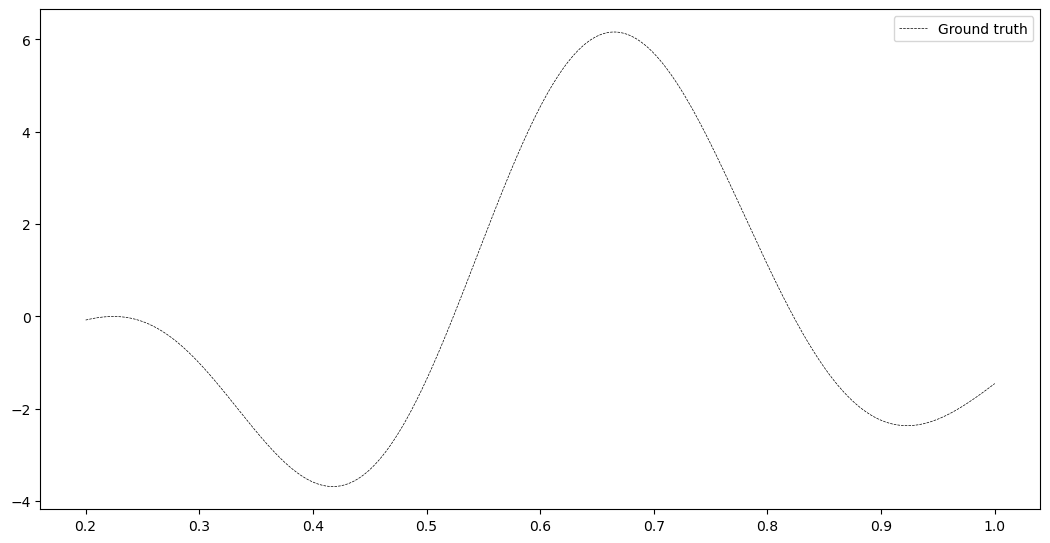

In [2]:
def function(x):
    return -(torch.sin(x*7)+torch.cos(14*x))*(x**2)*torch.exp(-4*x)*100

#range for sampling
xmin=0.2
xmax=1.00
points_plot=1000                              #resolution to plot the ground truth 
x_plot=torch.linspace(xmin, xmax, points_plot) 
y_plot=function(x_plot)

fig = plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='dashed',linewidth=0.5,color='k')
# ax.scatter(t2,PC,label=r"Predictions",color='g',s=10)
# plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)
plt.legend(prop={'size': 10})

In [3]:
training_samples = 500                   
x_data=np.random.uniform(xmin, xmax, training_samples)
x_data = torch.from_numpy(x_data.astype(np.float32)).view(-1,1)
y_data=function(x_data)
train_loader, _ = get_dataloader(x_data, y_data, 1, 1, train_test_split=1.0, batch_size=32)

x_batch,y_batch = next(iter(train_loader))  #to fix the x value in the reconstruction training
x_batch.shape, y_batch.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [4]:
class BayesianLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight_mu, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.weight_rho, -6)  # Initialize log variance to a small value
        nn.init.zeros_(self.bias_mu)
        nn.init.constant_(self.bias_rho, -6)

    # def reset_parameters(self):
    #     # Initialize weights and biases with normal distribution
    #     nn.init.normal_(self.weight_mu, mean=0, std=0.1)
    #     nn.init.normal_(self.weight_rho, mean=-3, std=0.1)
    #     nn.init.normal_(self.bias_mu, mean=0, std=0.1)
    #     nn.init.normal_(self.bias_rho, mean=-3, std=0.1)

    def forward(self, x):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        epsilon_weight = Variable(torch.randn_like(weight_sigma))
        epsilon_bias = Variable(torch.randn_like(bias_sigma))
        weight = self.weight_mu + weight_sigma * epsilon_weight
        bias = self.bias_mu + bias_sigma * epsilon_bias
        output = F.linear(x, weight, bias)
        return output, weight, bias

In [101]:
class BNN_BPP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BNN_BPP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the Bayesian neural network architecture based any number of hidden_sizes
        self.fc_mu_1 = BayesianLayer(input_size, hidden_sizes)
        self.fc_mu_2 = BayesianLayer(hidden_sizes, output_size)

        # def variational_loss(self, output_mu, output_log_var, target):
        #     recon_loss = F.mse_loss(output_mu, target, reduction='mean')
        #     kl_divergence = -0.5 * torch.sum(1 + output_log_var - output_mu.pow(2) - output_log_var.exp())
        #     return recon_loss , kl_divergence
        
    def forward(self, x):
        hidden_out, _ , _ = self.fc_mu_1(x)
        hidden_out  = F.relu(hidden_out)
        output , _ , _  = self.fc_mu_2(hidden_out)
        return output

    def train(self, train_loader, num_epochs=10, lr=1e-3, verbose=0):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                output_mu = self(inputs)
                recon_loss = F.mse_loss(output_mu, targets, reduction='mean')
                kl_loss = 0

                for layer in self.children():
                    if isinstance(layer, BayesianLayer):
                        weight_mu = layer.weight_mu
                        weight_rho = layer.weight_rho
                        bias_mu = layer.bias_mu
                        bias_rho = layer.bias_rho
                        # Compute KL divergence for weights
                        kl_loss += 0.5 * (torch.sum(weight_mu**2) + torch.sum(torch.log1p(torch.exp(weight_rho)) - weight_rho) - weight_mu.numel())
                        # Compute KL divergence for biases
                        kl_loss += 0.5 * (torch.sum(bias_mu**2) + torch.sum(torch.log1p(torch.exp(bias_rho)) - bias_rho) - bias_mu.numel())
                # loss_recons, kl_loss = self.variational_loss(output_mu, output_log_var, targets)
                kl_loss = kl_loss / 1000
                loss = recon_loss + (kl_loss)
                loss.backward()
                optimizer.step()

            if not verbose == 0: 
                # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss MSE: {recon_loss}, Loss KL: {kl_loss}')
            
        print(f'Epoch [{epoch+1}/{num_epochs}], total training loss: {loss.item()}')             


In [102]:
# Example usage
input_size = 1
hidden_sizes = 20
output_size = 1

net = BNN_BPP(input_size, hidden_sizes, output_size)
print(net)

BNN_BPP(
  (fc_mu_1): BayesianLayer()
  (fc_mu_2): BayesianLayer()
)


In [103]:
net.train(train_loader, num_epochs=1000, lr=1e-3, verbose=1)

Epoch [1/1000], Loss MSE: 6.665107727050781, Loss KL: 0.16874055564403534
Epoch [2/1000], Loss MSE: 9.675190925598145, Loss KL: 0.1680876463651657
Epoch [3/1000], Loss MSE: 9.161306381225586, Loss KL: 0.16744329035282135
Epoch [4/1000], Loss MSE: 6.974194526672363, Loss KL: 0.16680823266506195
Epoch [5/1000], Loss MSE: 11.365663528442383, Loss KL: 0.16618771851062775
Epoch [6/1000], Loss MSE: 5.871662139892578, Loss KL: 0.1655709445476532
Epoch [7/1000], Loss MSE: 11.155831336975098, Loss KL: 0.16494813561439514
Epoch [8/1000], Loss MSE: 10.09666919708252, Loss KL: 0.1643330603837967
Epoch [9/1000], Loss MSE: 7.832395076751709, Loss KL: 0.16372941434383392
Epoch [10/1000], Loss MSE: 8.903972625732422, Loss KL: 0.16311883926391602
Epoch [11/1000], Loss MSE: 9.400113105773926, Loss KL: 0.16252082586288452
Epoch [12/1000], Loss MSE: 10.231191635131836, Loss KL: 0.16193152964115143
Epoch [13/1000], Loss MSE: 8.488205909729004, Loss KL: 0.16134533286094666
Epoch [14/1000], Loss MSE: 10.3192

In [ ]:
class BNN_BPP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BNN_BPP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the Bayesian neural network architecture based any number of hidden_sizes
        self.fc_mu = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])

        for i in range(len(hidden_sizes) - 1):   #adding  layers for mu and log_var
            self.fc_mu.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.fc_mu.append(nn.Linear(hidden_sizes[-1], output_size))
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # Define loss function (variational lower bound)
    def variational_loss(self, output_mu, output_log_var, target):
        recon_loss = F.mse_loss(output_mu, target, reduction='mean')
        kl_divergence = -0.5 * torch.sum(1 + output_log_var - output_mu.pow(2) - output_log_var.exp())
        return recon_loss , kl_divergence
    
    def train(self, train_loader,num_epochs=10, lr=1e-3, verbose=0):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            for inputs, targets in train_loader:       
                optimizer.zero_grad()
                output_mu, output_log_var = self(inputs)
                loss_recons, kl_loss = self.variational_loss(output_mu, output_log_var, targets)
                loss = loss_recons + kl_loss
                loss.backward()
                optimizer.step()

            if not verbose == 0: 
                # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss MSE: {loss_recons}, Loss KL: {kl_loss}')
            
        print(f'Epoch [{epoch+1}/{num_epochs}], total loss: {loss.item()}')
        
    def forward(self, x):
        # Encoder
        hidden_mu = F.relu(self.fc_mu[0](x))
        hidden_log_var = F.relu(self.fc_log_var[0](x))
        
        # Reparameterization trick
        hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
        
        # Decoder
        for i in range(1, len(self.fc_mu)-1):   #predictions with Reparameterization over all layers but last one (modified)
            # print(hidden_rep.shape, i)
            hidden_mu = F.relu(self.fc_mu[i](hidden_rep))
            hidden_log_var = F.relu(self.fc_log_var[i](hidden_rep))
            hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
            # print(hidden_rep.shape, i)
        
        output_mu = self.fc_mu[-1](hidden_rep)
        output_log_var = self.fc_log_var[-1](hidden_rep)
        
        return output_mu, output_log_var

In [ ]:
# #range for sampling
# points_plot=1000                              #resolution of the ground truth 
# x_plot=np.linspace(xmin,xmax,points_plot) 
# y_plot=function(x_plot)

# x_train_net = torch.from_numpy(x_plot.astype(np.float32)).view(-1,1)
# y_bnn = net.predict(x_train_net).cpu().detach().numpy()
# y_bnn_pred = net.sample_predict(x_train_net, Nsamples=10).cpu().detach().numpy()
# y_bnn_mean = np.mean(y_bnn_pred, axis=0)
# y_bnn_std = np.std(y_bnn_pred, axis=0)

# fig = plt.figure(figsize=(10,5))
# ax=fig.add_axes([0,0,1,1])
# ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='dashed',linewidth=0.5,color='k')
# ax.plot(x_plot, y_bnn,label=r"BNN",linestyle='dashed',linewidth=1,color='b')
# ax.plot(x_plot, y_bnn_mean,label=r"BNN_mean",linestyle='dashed',linewidth=0.5,color='r')
# ax.plot(x_plot, y_bnn_mean+y_bnn_std,label=r"BNN_std",linestyle='dashed',linewidth=0.5,color='g')
# ax.plot(x_plot, y_bnn_mean-y_bnn_std,label=r"BNN_std",linestyle='dashed',linewidth=0.5,color='g')
# # ax.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
# # ax.scatter(t2,PC,label=r"Predictions",color='g',s=10)
# plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)

In [ ]:
class BNN_BPP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BNN_BPP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the Bayesian neural network architecture based any number of hidden_sizes
        self.fc_mu = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.fc_log_var = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        for i in range(len(hidden_sizes) - 1):   #adding  layers for mu and log_var
            self.fc_mu.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.fc_log_var.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.fc_mu.append(nn.Linear(hidden_sizes[-1], output_size))
        self.fc_log_var.append(nn.Linear(hidden_sizes[-1], output_size))
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # Define loss function (variational lower bound)
    def variational_loss(self, output_mu, output_log_var, target):
        recon_loss = F.mse_loss(output_mu, target, reduction='mean')
        kl_divergence = -0.5 * torch.sum(1 + output_log_var - output_mu.pow(2) - output_log_var.exp())
        return recon_loss , kl_divergence
    
    def train(self, train_loader,num_epochs=10, lr=1e-3, verbose=0):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            for inputs, targets in train_loader:       
                optimizer.zero_grad()
                output_mu, output_log_var = self(inputs)
                loss_recons, kl_loss = self.variational_loss(output_mu, output_log_var, targets)
                loss = loss_recons + kl_loss
                loss.backward()
                optimizer.step()

            if not verbose == 0: 
                # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss MSE: {loss_recons}, Loss KL: {kl_loss}')
            
        print(f'Epoch [{epoch+1}/{num_epochs}], total loss: {loss.item()}')
        
    def forward(self, x):
        # Encoder
        hidden_mu = F.relu(self.fc_mu[0](x))
        hidden_log_var = F.relu(self.fc_log_var[0](x))
        
        # Reparameterization trick
        hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
        
        # Decoder
        for i in range(1, len(self.fc_mu)-1):   #predictions with Reparameterization over all layers but last one (modified)
            # print(hidden_rep.shape, i)
            hidden_mu = F.relu(self.fc_mu[i](hidden_rep))
            hidden_log_var = F.relu(self.fc_log_var[i](hidden_rep))
            hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
            # print(hidden_rep.shape, i)
        
        output_mu = self.fc_mu[-1](hidden_rep)
        output_log_var = self.fc_log_var[-1](hidden_rep)
        
        return output_mu, output_log_var